In [1]:
from typing import Union
import os
from pathlib import Path
import os
import sys
from fastai2.vision.all import *
from shutil import copyfile
sys.path.append(str(Path(os.path.abspath('')).parent / "ceruleanserver"))
from configs import aws_config
from utils import s3


In [2]:
datapath = Path(os.path.abspath('')) / "data"
modelpath = "."


In [3]:




if not datapath.exists():
    os.mkdir(datapath)

if not any(x for x in datapath.iterdir()):
    bucket = s3.get_s3_bucket(aws_config.S3_BUCKET_NAME)
    s3.download_prefix(
        bucket, datapath, aws_config.S3_TRAINING_DATA_PATH, recursive=True
    )


/home/ubuntu/anaconda3/envs/cerulean/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


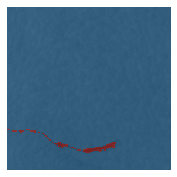

In [4]:
oil_chps = np.loadtxt(datapath / "oil_chps.txt", dtype=str)
codes = np.loadtxt(datapath / "codes.txt", dtype=str)
valid_names = np.loadtxt(datapath / "valid_names.txt", dtype=str)


def get_chps(path):
    return [path / "chp" / (chp + ".png") for chp in oil_chps]


def get_lbls(fn):
    return fn.parent.parent / "lbl" / f"{fn.name}"


def splitter_func(fn):
    return (
        fn.name.rsplit("_", 1)[0] in valid_names
    )  # XXX Check to make sure this should be returning True for Valid


size = 128  # Progressive resizing could happen here

augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)

seg_db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items=get_chps,
    splitter=FuncSplitter(splitter_func),
    batch_tfms=augs,
    get_y=get_lbls,
)

dls = SegmentationDataLoaders.from_dblock(
    dblock=seg_db, source=datapath, path=datapath, bs=1
)

dls.show_batch(vmin=0, vmax=3)


In [ ]:
arch = 50
archs = {18: resnet18, 34: resnet34, 50: resnet50}

learn = unet_learner(dls, archs[arch], metrics=[Dice()]) #model_dir=modelpath

# learn.load('/content/data/34_256_.683')

# learn.lr_find()

learn.fine_tune(8, 3e-3, cbs=SaveModelCallback(monitor="dice"))

#learn.load("model")

savename = f"{arch}_{size}_{round(learn.validate()[1],3)}.pkl"
learn.export(modelpath / savename)

learn.show_results(max_n=6, figsize=(20, 20), vmin=0, vmax=3)




epoch,train_loss,valid_loss,dice,time
